# Task description

A taxi company called Sweet Lift has collected historical data about taxi orders at airports. In order to attract more drivers during peak hours, it is necessary to predict the number of taxi orders for the next hour. Create a model for such predictions.

The RMSE metric on *test set* cannot be more than 48.

## Task instructions

1. Download data and do *resampling* in one hour.
2. Analysis of the data.
3. Train different models with different hyperparameters. The test sample must be 10% of the initial *dataset*.
4. Test the data using a test sample and provide a conclusion.

## Data description

The data is stored in the `taxi.csv` file. The number of orders in column'*num_orders*'.

## Preparation

In [3]:
#import pandas and numpy for data preprocessing and manipulation
import pandas as pd

# matplotlib and seaborn for visualization
import matplotlib.pyplot as plt

# import statistics models
from statsmodels.tsa.seasonal import seasonal_decompose

# import module for splitting
from sklearn.model_selection import train_test_split

#import module for StandarScalling
from sklearn.preprocessing import StandardScaler as ss

#import machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

#import metric to measure quality of model
from sklearn.metrics import mean_squared_error

### Reading Data

In [4]:
df = pd.read_csv('/datasets/taxi.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum().sort_values(ascending=False)

datetime      0
num_orders    0
dtype: int64

In [8]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [9]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [10]:
df.tail()

,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


In [11]:
df.shape

(26496, 2)

In [12]:
df['datetime'].min(), df['datetime'].max()

('2018-03-01 00:00:00', '2018-08-31 23:50:00')

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
From the steps above and reading the data taken from the file '/datasets/taxi.csv', it is known that the file has 2 columns and 26496 rows. There are no duplicate values ​​or null values ​​in the dataframe. The data includes 6 months from March to August 2018.
Then perform Data Preprocessing with the following steps:

- Make datetime of type date
- Make the datetime an index on the dataframe
- Checks whether the datetime is in chronological order
- Resample the data with 1 hour because you need to predict the number of taxi orders for the next hour
- The target is numeric, so this is a Regression Task
     
</div>

In [13]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [14]:
df.sort_index(inplace=True)

In [15]:
df.index.is_monotonic

True

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
Datetime is a chronology order
     
</div>

## Analysis

### Resampling

In [16]:
#Resampling
ts = df.resample('1H').sum()

In [17]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [18]:
ts.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Rolling Mean and Rolling Std

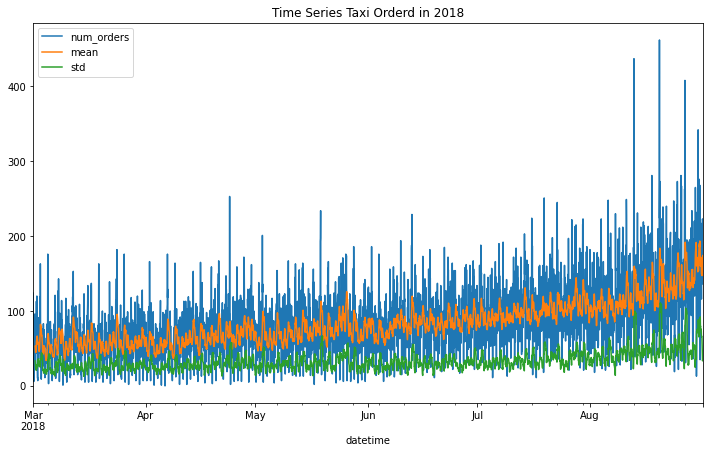

In [19]:
ts = ts.resample('1H').sum()
ts['mean'] = ts['num_orders'].rolling(15).mean()
ts['std'] = ts['num_orders'].rolling(15).std()
ts.plot(figsize=(12,7), title='Time Series Taxi Orderd in 2018');

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
You can see the trend in the plot above. This means that we can use time series to model data and generate forecasts. We can analyze data using various time series components.
     
</div>

In [20]:
ts.isnull().sum()

num_orders     0
mean          14
std           14
dtype: int64

In [21]:
ts = ts.drop(['mean','std'], axis=1)

### Seasonal (Trend, Seasonality, and Residuals)

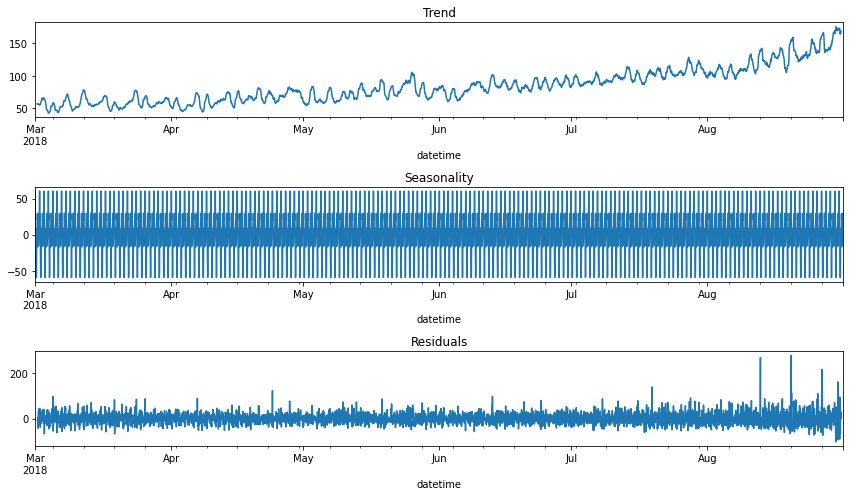

In [22]:
decomposed =seasonal_decompose(ts)

plt.figure(figsize=(12, 7))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<div style="background-color:rgba(0, 255, 172, 0.07)"
     
From the plot above it can be concluded the following things:
- From the Trend plot, you can see an increase in taxi orders from March to August
- From the Seasonality plot, the pattern cannot be seen because the data only contains 6 months
- The Residuals plot shows a stationary stochastic process, the residual level does not change over time, so it does not affect predictions
     
</div>

In [23]:
#Mengambil fragmen arbitrer dari masing-masing plot Trend, Seasonality, dan Residuals
print(decomposed.trend[4:6] + decomposed.seasonal[4:6] + decomposed.resid[4:6])
print()
print(ts[4:6]) 

datetime
2018-03-01 04:00:00   NaN
2018-03-01 05:00:00   NaN
Freq: H, dtype: float64

                     num_orders
datetime                       
2018-03-01 04:00:00          43
2018-03-01 05:00:00           6


### Weekly Pattern

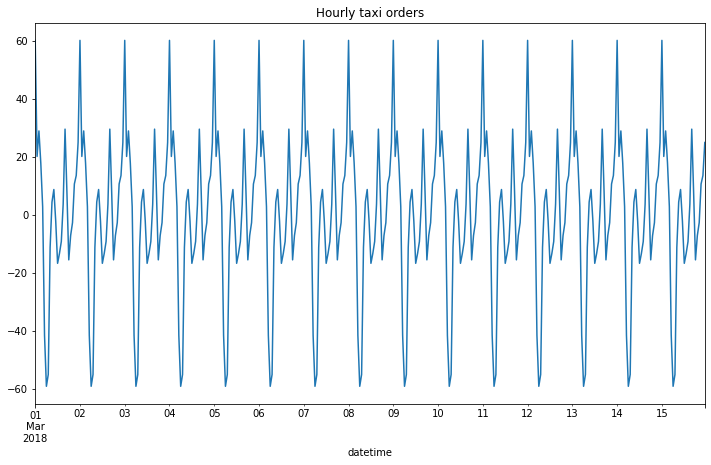

In [24]:
plt.figure(figsize=(12, 7))
decomposed.seasonal['2018-03-01':'2018-03-15'].plot()
plt.title('Hourly taxi orders');

## Training

### Features Engineering

In [25]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hourofday'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()
    
make_features(ts, 10, 5)

In [26]:
#ts.head()

### Splitting the Data

In [27]:
#Drop null value
ts = ts.dropna()

In [28]:
ts.head()

,num_orders,month,day,dayofweek,hourofday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,27.2,25.606640
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,38.8,26.715164
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,55.6,31.611707
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,58.6,27.199265
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,58.2,27.662249


In [29]:
features = ts.drop('num_orders', axis=1)
target = ts['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [30]:
print('Train Set from', features_train.index.min(), 'until', features_train.index.max())
print('Test Set From', features_test.index.min(), 'until', features_test.index.max())

Train Set from 2018-03-01 10:00:00 until 2018-08-13 14:00:00
Test Set From 2018-08-13 15:00:00 until 2018-08-31 23:00:00


### Standar Scalling

In [31]:
sc = ss()
features_train = sc.fit_transform(features_train)
features_test = sc.transform(features_test)

In [32]:
features_train

array([[-1.4167566 , -1.59754669, -0.01245892, ...,  1.18398845,
        -1.82570726, -0.11268372],
       [-1.4167566 , -1.59754669, -0.01245892, ...,  0.1750275 ,
        -1.41129065, -0.02454918],
       [-1.4167566 , -1.59754669, -0.01245892, ..., -0.18716361,
        -0.81110108,  0.36475616],
       ...,
       [ 1.75371407, -0.24320146, -1.50941674, ...,  9.28154683,
         1.25383684,  1.69438404],
       [ 1.75371407, -0.24320146, -1.50941674, ...,  2.32230337,
         1.63252788,  0.27147601],
       [ 1.75371407, -0.24320146, -1.50941674, ...,  1.67553353,
         1.83259107, -0.16680751]])

### Linear Regression for sanity check

In [33]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)
predicted_train = model.predict(features_train)
predicted_test = model.predict(features_test)

print("Train RMSE :", mean_squared_error(target_train, predicted_train, squared=False).round(2))
print("Test RMSE :", mean_squared_error(target_test, predicted_test, squared=False).round(2))

Train RMSE : 29.88
Test RMSE : 53.63
CPU times: user 6.11 ms, sys: 60.6 ms, total: 66.7 ms
Wall time: 25.9 ms


### RandomForest Regression with HyperParameter Tuning

In [34]:
%%time

model = RandomForestRegressor(n_estimators=100, max_depth=8)
model.fit(features_train, target_train)
predicted_train = model.predict(features_train)
predicted_test = model.predict(features_test)

print("Train RMSE :", mean_squared_error(target_train, predicted_train, squared=False).round(2))
print("Test RMSE :", mean_squared_error(target_test, predicted_test, squared=False).round(2))

Train RMSE : 18.55
Test RMSE : 47.04
CPU times: user 2.64 s, sys: 0 ns, total: 2.64 s
Wall time: 2.75 s


In [35]:
%%time

d=[]
list_estimator = [100,200,300]
for est in list_estimator:
    model = RandomForestRegressor(random_state = 12345, n_estimators=est)
    model.fit(features_train, target_train)
    predicted_test = model.predict(features_test)
    rmse_score = mean_squared_error(target_test, predicted_test) ** 0.5
    d.append(
        {
            'estimator': est,
            'rmse_score': rmse_score
        }
    )

best_param = pd.DataFrame(d).nsmallest(1, ['rmse_score'], keep='first')
rmse_score = best_param['rmse_score'].values
best_param

CPU times: user 27.7 s, sys: 0 ns, total: 27.7 s
Wall time: 27.8 s


,estimator,rmse_score
2,300,44.011361


### XGBoost with HyperParameter Tuning

In [36]:
%%time

d=[]
list_estimator = [100,200,300]
for est in list_estimator:
    model = XGBRegressor(random_state = 12345, n_estimators=est, n_jobs=-1)
    model.fit(features_train, target_train)
    predicted_test = model.predict(features_test)
    rmse_score = mean_squared_error(target_test, predicted_test) ** 0.5
    d.append(
        {
            'estimator': est,
            'rmse_score': rmse_score
        }
    )

best_param = pd.DataFrame(d).nsmallest(1, ['rmse_score'], keep='first')
rmse_score = best_param['rmse_score'].values
best_param

CPU times: user 2min 22s, sys: 1.2 s, total: 2min 24s
Wall time: 2min 25s


,estimator,rmse_score
0,100,45.126358


### LGBM with HyperParameter Tuning

In [37]:
%%time

d=[]
list_estimator = [100,200,300]
for est in list_estimator:
    model = LGBMRegressor(random_state = 12345, n_estimators=est)
    model.fit(features_train, target_train)
    predicted_test = model.predict(features_test)
    rmse_score = mean_squared_error(target_test, predicted_test) ** 0.5
    d.append(
        {
            'estimator': est,
            'rmse_score': rmse_score
        }
    )

best_param = pd.DataFrame(d).nsmallest(1, ['rmse_score'], keep='first')
rmse_score = best_param['rmse_score'].values
best_param

CPU times: user 4.72 s, sys: 63.1 ms, total: 4.78 s
Wall time: 4.81 s


,estimator,rmse_score
1,200,42.536248


### CatBoost with HyperParameter Tuning

In [36]:
%%time

d=[]
iteration = [100,200,300]
for iterate in iteration:
    model = CatBoostRegressor(random_state = 12345, iterations=iterate, verbose=False)
    model.fit(features_train, target_train)
    predicted_test = model.predict(features_test)
    rmse_score = mean_squared_error(target_test, predicted_test) ** 0.5
    d.append(
        {
            'estimator': est,
            'rmse_score': rmse_score
        }
    )

best_param = pd.DataFrame(d).nsmallest(1, ['rmse_score'], keep='first')
rmse_score = best_param['rmse_score'].values
best_param

CPU times: user 2.87 s, sys: 11.9 ms, total: 2.88 s
Wall time: 3.24 s


,estimator,rmse_score
2,300,43.196707


## Pengujian

In [37]:
%%time

d=[]
list_estimator = [100,200,300]
for est in list_estimator:
    model = LGBMRegressor(random_state = 12345, n_estimators=est)
    model.fit(features_train, target_train)
    predicted_test = model.predict(features_test)
    rmse_score = mean_squared_error(target_test, predicted_test) ** 0.5
    d.append(
        {
            'estimator': est,
            'rmse_score': rmse_score
        }
    )

best_param = pd.DataFrame(d).nsmallest(1, ['rmse_score'], keep='first')
rmse_score = best_param['rmse_score'].values
best_param

CPU times: user 23.4 s, sys: 197 ms, total: 23.6 s
Wall time: 23.7 s


,estimator,rmse_score
1,200,42.536248


In [38]:
model = ['Linear Regression', 'Random Forest Regressor', 'XGBoost Regressor', 'LightGBM Regressor', 'Catboost Regressor']
rmse = [53.63, 44.0, 45.12, 42.53, 43.19 ]
wall_time = [13.8, 25.89, 22.9, 4.44, 2.94 ]

In [39]:
data_model = {'model':model, 'rmse_score':rmse, 'time_in_sec':wall_time}
df_model = pd.DataFrame(data=data_model)
df_model

,model,rmse_score,time_in_sec
0,Linear Regression,53.63,13.80
1,Random Forest Regressor,44.00,25.89
2,XGBoost Regressor,45.12,22.90
3,LightGBM Regressor,42.53,4.44
4,Catboost Regressor,43.19,2.94


<div style="background-color:rgba(0, 255, 172, 0.07)"

From the analysis, we can see that among the different models, linear regression has the worst rmse, which is ~53. Meanwhile, LGBM has the best score of ~42.53. The aim of this project is to develop a model to determine the number of taxi orders for the next hour based on historical data. The RMSE metric on the test set should be no more than 48. So the LGBM model is the best model to use.
</div>